In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

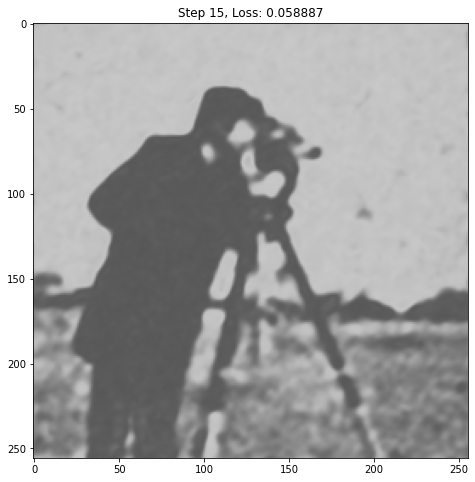

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


In [5]:
# SIREN network
# Code adapted from the following GitHub repository:
# https://github.com/vsitzmann/siren?tab=readme-ov-file
from torch import nn
import torch
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
import matplotlib
from IPython import display

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a    # hyperparameter.
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                            1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))
        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                             np.sqrt(6 / hidden_features) / hidden_omega_0)
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))
        self.net = nn.Sequential(*self.net)
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)  # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords
    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()
        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)
                if retain_grad:
                    x.retain_grad()
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1
        return activations

class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
    def __len__(self):
        return 1
    def __getitem__(self, idx):
        if idx > 0: raise IndexError
        return self.coords, self.pixels

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)
def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i + 1]
    return div
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

if __name__ == '__main__':
    device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        matplotlib.use("Qt5Agg")
    except:
        pass
    cameraman = ImageFitting(256)
    dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)
    img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                      hidden_layers=3, outermost_linear=True, first_omega_0=80, hidden_omega_0=80.)
    img_siren.cpu()
    total_steps = 20  # Since the whole image is our dataset, this just means 500 gradient descent steps.
    steps_til_summary = 5
    optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
    model_input, ground_truth = next(iter(dataloader))
    #model_input, ground_truth = model_input.cpu(), ground_truth.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    img_display = ax.imshow(np.zeros((256, 256)), cmap='Greys_r', vmin=-1, vmax=1)
    title = ax.set_title("Step 0")

    for step in trange(total_steps):
        model_output, coords = img_siren(model_input)
        # model_output = gradient(model_output, coords)
        # model_output = laplace(model_output, coords)
        loss = ((model_output - ground_truth) ** 2).mean()
        if not step % steps_til_summary:
            title.set_text(f"Step {step}, Loss: {loss.item():.6f}")
            img_display.set_data(model_output.view(256, 256).detach().numpy())
            # img_grad = gradient(model_output, coords)
            # img_display.set_data(img_grad.norm(dim=-1).view(256, 256).detach().numpy())
            # img_laplacian = laplace(model_output, coords)
            # img_display.set_data(img_laplacian.view(256, 256).detach().numpy())
            display.clear_output(wait=True)
            display.display(fig)
            # plt.savefig(f"tmp/output_{step}.png")
        optim.zero_grad()
        loss.backward()
        optim.step()

plt.close()

In [6]:
print(device)

cpu


super resolved


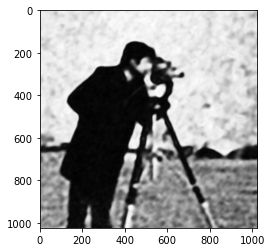

In [7]:
# upsampling neural field
n = 1024
coords = torch.linspace(-1, 1, steps=n).to(device)
x, y = torch.meshgrid(coords, coords, indexing='xy')
pos_mesh = torch.stack([y.flatten(), x.flatten()], dim=1).unsqueeze(0)
mesh_size = 1 / n

with torch.no_grad():
    model_output, coords = img_siren(pos_mesh)

print('super resolved')

model_output = model_output.view(n, n).cpu().numpy()
plt.imshow(model_output, cmap='gray')
plt.show()

In [9]:
from torch import nn
import torch
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
import matplotlib

def get_cameraman_tensor(sidelength) -> Image:
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

cmt = get_cameraman_tensor(256)
cmt = cmt.permute(1, 2, 0)

In [ ]:
cmt.view(-1, 1).shape

torch.Size([65536, 1])

: 